In [31]:
# imports and plotting utility functions
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import Lasso
import seaborn as sns
from matplotlib import pylab as plt
from statsmodels.regression.linear_model import OLS

def plot_lr(true_coefs, est_coefs, pvals, var_names=None):
    n_feat = len(est_coefs)
    where_sign = lr_pvalues < 0.05
    plt.figure(figsize=(15, 7))
    if true_coefs is not None:
        plt.scatter(np.arange(X.shape[1]), true_coefs, color='black', label='true betas', alpha=0.5)
    # print non-significant betas
    plt.scatter(np.arange(X.shape[1]), est_coefs, color='red', label='estimated betas', alpha=0.5)
    # print significant betas
    axes = plt.gca()
    y_max, _ = axes.get_ylim()
    sign_y = np.sum(where_sign) * [y_max]
    plt.scatter(np.arange(X.shape[1])[where_sign], sign_y, color='red', label='significant at p<0.05', s=150, marker=(5, 1), alpha=0.75, linewidth=3)

    plt.xlabel('input variables')
    #plt.xticks(np.arange(n_feat)[::2], (np.arange(n_feat) + 1)[::2])
    if var_names is None:
        plt.xticks(np.arange(n_feat), (np.arange(n_feat) + 1))
    else:
        plt.xticks(np.arange(n_feat), var_names)
    plt.grid(True)
    plt.title('Linear regression', fontsize=16)
    plt.legend(loc='upper right')

def plot_regr_paths(coefs, accs, nonzeros, C_grid, var_names=None):
    n_cols = 2
    n_rows = 1
    n_verticals = len(coefs)
    n_feat = len(coefs)

    my_palette = np.array([
        '#F47D7D', '#FBEF69', '#98E466', '#000000',
        '#A7794F', '#CCCCCC', '#85359C', '#FF9300', '#FF0030', 'grey', 'blue', 'salmon', '#4BBCF6',
        'green', 'tomato', 'darkred', 'black', 'cyan', 'lime'
    ])
    my_colors = np.array(['???????'] * coefs.shape[-1])
    i_col = 0
    new_grp_pts_x = []
    new_grp_pts_y = []
    new_grp_pts_col = []
    new_grp_pts_total = []

    for i_vertical, (params, acc, C) in enumerate(zip(
        coefs, accs, C_grid)):
        b_notset = my_colors == '???????'
        b_nonzeros = params == 0
        b_coefs_of_new_grp = np.logical_and(b_notset, b_nonzeros)

        #if i_vertical >= 17:
        #    import pdb; pdb.set_trace()

        if np.sum(b_coefs_of_new_grp) > 0:
            i_col += 1

            # we found a new subset that became 0
            for new_i in np.where(b_coefs_of_new_grp == True)[0]:
                # color all coefficients of the current group
                cur_col = my_palette[i_col]
                my_colors[new_i] = cur_col

            new_grp_pts_x.append(C)
            new_grp_pts_y.append(acc)
            new_grp_pts_col.append(cur_col)
            new_grp_pts_total.append(np.sum(b_nonzeros))

    if var_names is None:
        X_colnames = np.arange(n_feat) + 1
    else:
        X_colnames = var_names
            
    subplot_xlabel = '#nonzero coefficients'

    f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols,
        figsize=(15, 10), facecolor='white')
    t, i_col = 0, 0

    for i_line in range(X.shape[-1]):
        axarr[i_col].plot(np.log10(C_grid),
            coefs[:, i_line], label=X_colnames[i_line],
                color=my_colors[i_line], linewidth=1.5)

    # axarr[0].set_xticks(np.arange(len(C_grid)))
    # axarr[0].set_xticklabels(np.log10(C_grid))  #, rotation=75)
    axarr[i_col].set_xlabel(subplot_xlabel, fontsize=10)
    axarr[i_col].legend(loc='lower left', fontsize=8.5, markerscale=10)
    axarr[0].grid(True)
    # axarr[i_col].set_ylabel('Item groups', fontsize=16)
    axarr[0].set_title('LASSO: Groups of selected variables', fontsize=16)
    axarr[0].set_xticks(np.log10(C_grid))
    axarr[0].set_xticklabels(nonzeros)

    # axarr[1].axis('off')
    axarr[1].plot(np.arange(len(accs)), accs, color='#000000',
                     linewidth=3)
    # axarr[1].set_title('ACCURACY')
    axarr[1].set_ylim(0.0, 1.05)
    axarr[1].grid(True)
    # axarr[1].set_xticklabels(np.log10(C_grid), '')
    axarr[1].set_xticks(np.arange(n_verticals))
    axarr[1].set_xticklabels(nonzeros)
    axarr[1].set_xlabel(subplot_xlabel, fontsize=10)
    # axarr[1].set_ylabel('Out-of-sample accuracy', fontsize=16)
    axarr[1].set_title('LASSO: Out-of-sample accuracy ($R^2$ score)', fontsize=16)

    
def corrfunc(x, y, **kws):
    from scipy import stats
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

In [2]:
# statistical helper functions
def compute_Lasso_regpath(X, y, C_grid):
    coef_list2 = []
    acc_list2 = []
    nonzero_list2 = []
    for i_step, my_C in enumerate(C_grid):
        sample_accs = []
        sample_coef = []
        for i_subsample in range(100):
            folder = ShuffleSplit(n=len(y), n_iter=100, test_size=0.1,
                                            random_state=i_subsample)
            train_inds, test_inds = iter(folder).next()

            clf = Lasso(alpha=my_C, random_state=i_subsample)

            clf.fit(X[train_inds, :], y[train_inds])
            acc = clf.score(X[test_inds, :], y[test_inds])

            sample_accs.append(acc)        
            sample_coef.append(clf.coef_)

        mean_coefs = np.mean(np.array(sample_coef), axis=0)
        coef_list2.append(mean_coefs)
        acc_list2.append(np.mean(sample_accs))
        notzero = np.count_nonzero(mean_coefs)
        print "alpha: %.4f acc: %.2f active_coefs: %i" % (my_C, acc, notzero)
        nonzero_list2.append(notzero)
    return np.array(coef_list2), np.array(acc_list2), np.array(nonzero_list2)

Diabetes dataset
================

Notes
-----

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attributes:
    :Age:
    :Sex:
    :Body mass index:
    :Average blood pressure:
    :S1:
    :S2:
    :S3:
    :S4:
    :S5:
    :S6:

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499.
(http://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf)

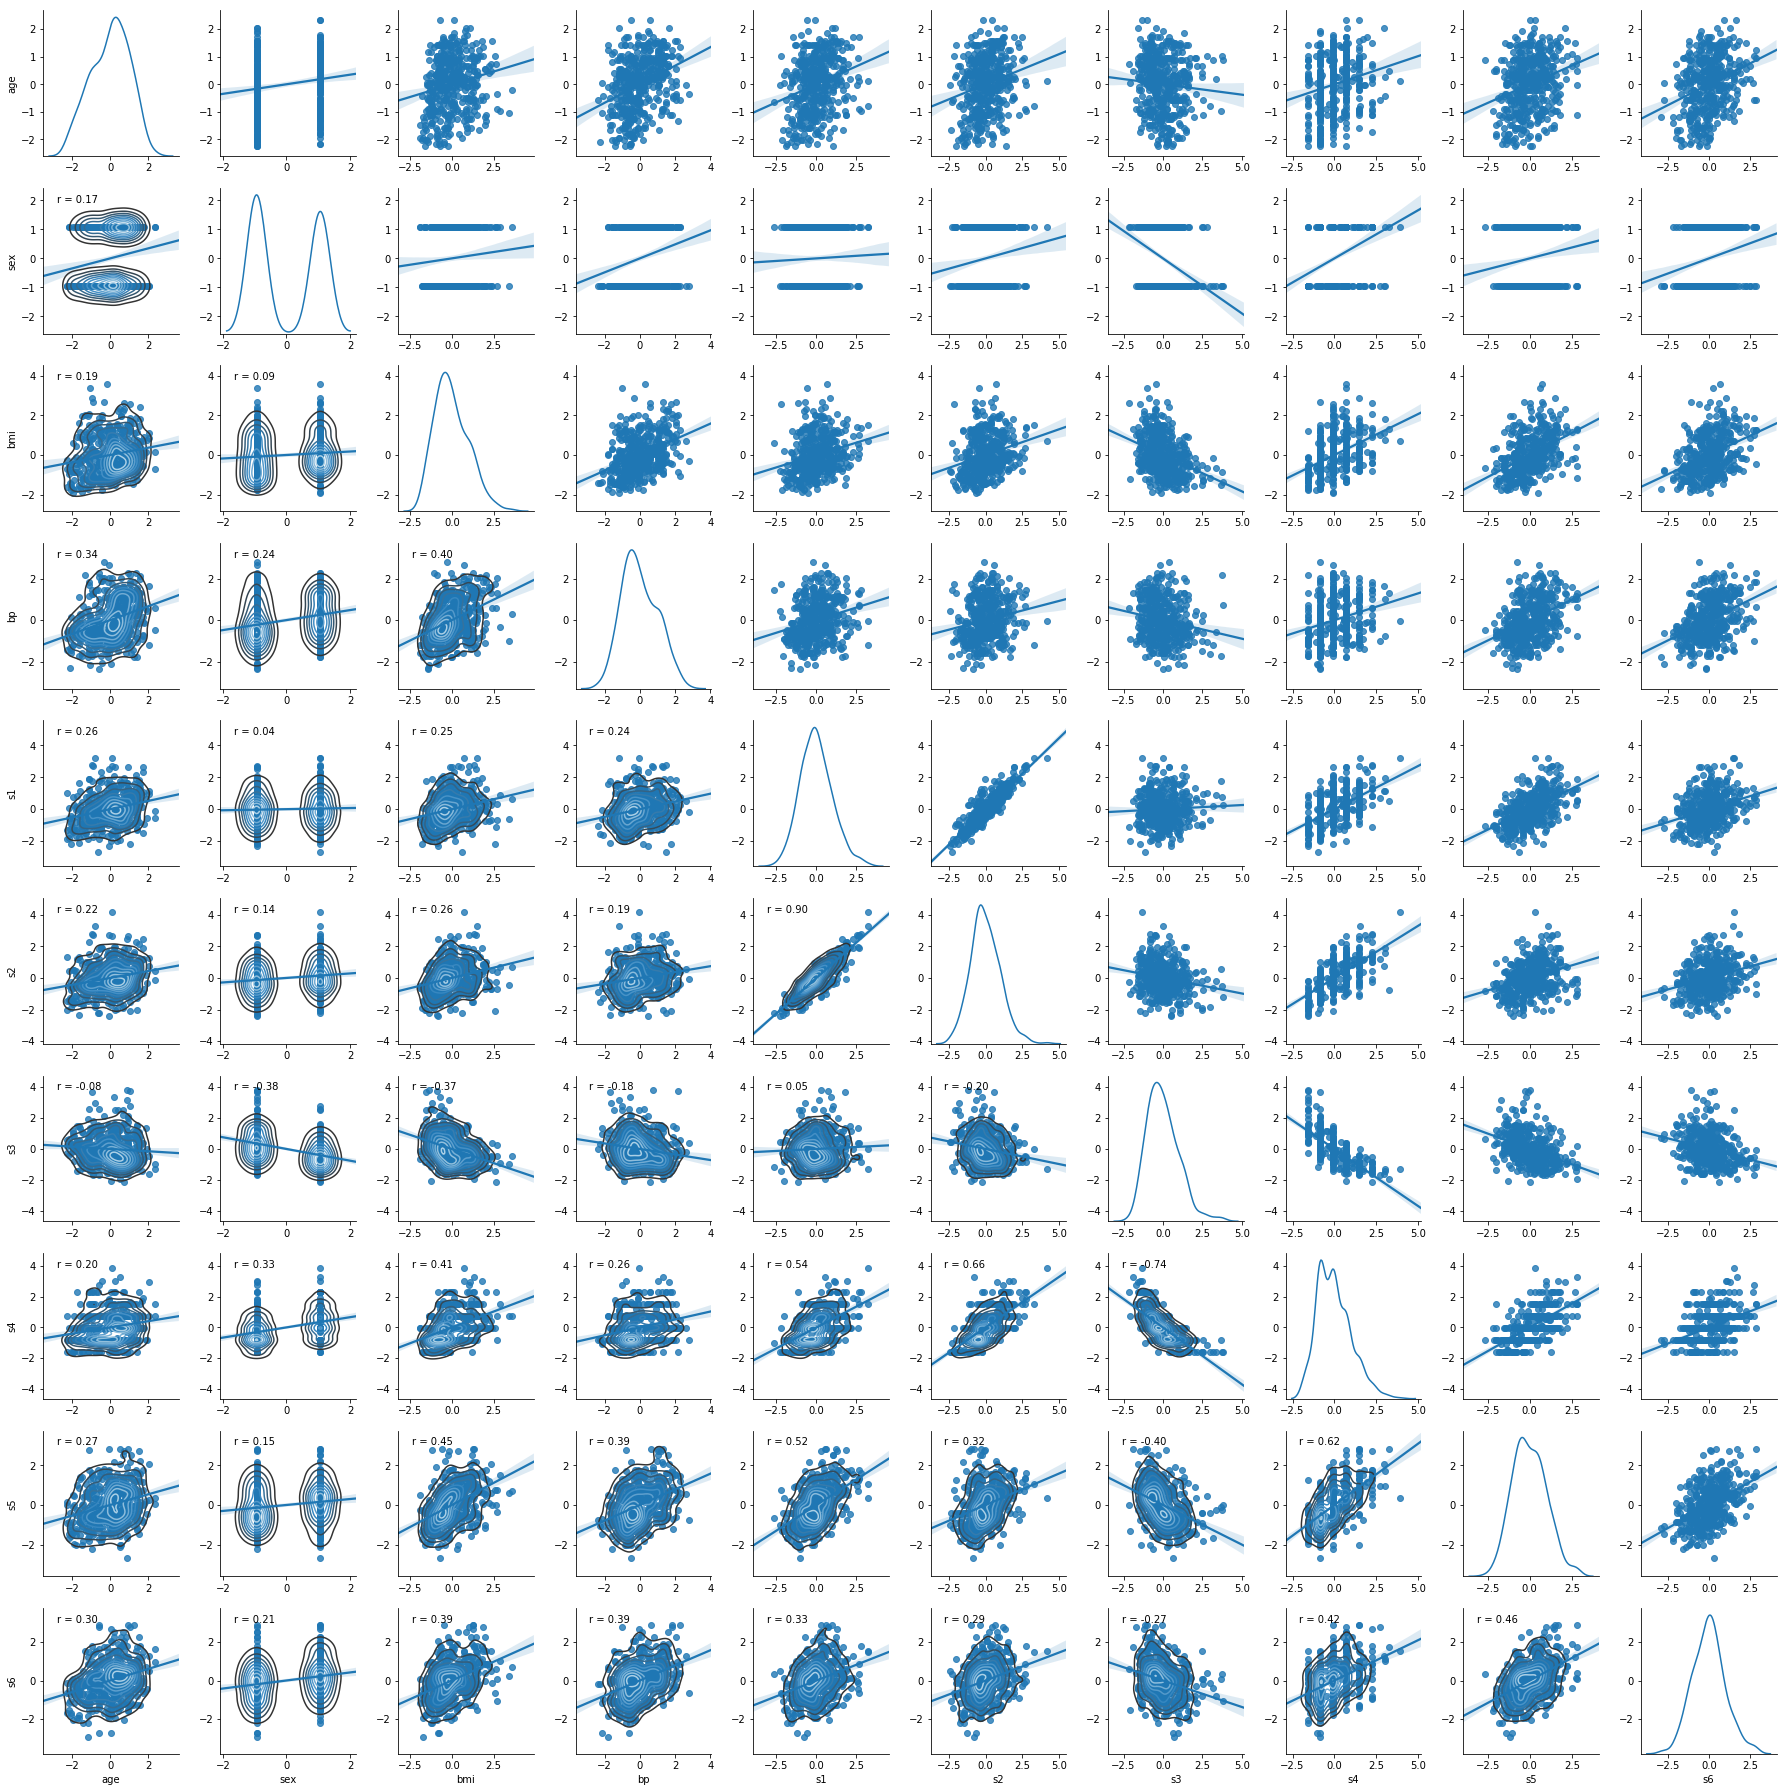

In [32]:
import sklearn.datasets as ds  
bun = ds.load_diabetes()
X, y = bun.data, bun.target
X = StandardScaler().fit_transform(X)
feat_names = bun.feature_names

g = sns.pairplot(pd.DataFrame(X, columns=feat_names), kind="reg", diag_kind="kde")
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

#sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
#             kind="reg", diag_kind="kde",
#             hue='out')

alpha: 0.0100 acc: 0.51 active_coefs: 10
alpha: 0.0147 acc: 0.51 active_coefs: 10
alpha: 0.0215 acc: 0.51 active_coefs: 10
alpha: 0.0316 acc: 0.51 active_coefs: 10
alpha: 0.0464 acc: 0.51 active_coefs: 10
alpha: 0.0681 acc: 0.51 active_coefs: 10
alpha: 0.1000 acc: 0.51 active_coefs: 10
alpha: 0.1468 acc: 0.50 active_coefs: 10
alpha: 0.2154 acc: 0.50 active_coefs: 10
alpha: 0.3162 acc: 0.50 active_coefs: 10
alpha: 0.4642 acc: 0.50 active_coefs: 9
alpha: 0.6813 acc: 0.50 active_coefs: 9
alpha: 1.0000 acc: 0.50 active_coefs: 9
alpha: 1.4678 acc: 0.50 active_coefs: 10
alpha: 2.1544 acc: 0.49 active_coefs: 8
alpha: 3.1623 acc: 0.49 active_coefs: 8
alpha: 4.6416 acc: 0.49 active_coefs: 7
alpha: 6.8129 acc: 0.48 active_coefs: 6
alpha: 10.0000 acc: 0.46 active_coefs: 5
alpha: 14.6780 acc: 0.41 active_coefs: 4
alpha: 21.5443 acc: 0.34 active_coefs: 3
alpha: 31.6228 acc: 0.19 active_coefs: 2
alpha: 46.4159 acc: -0.01 active_coefs: 1
alpha: 68.1292 acc: -0.01 active_coefs: 0
alpha: 100.0000 acc: 

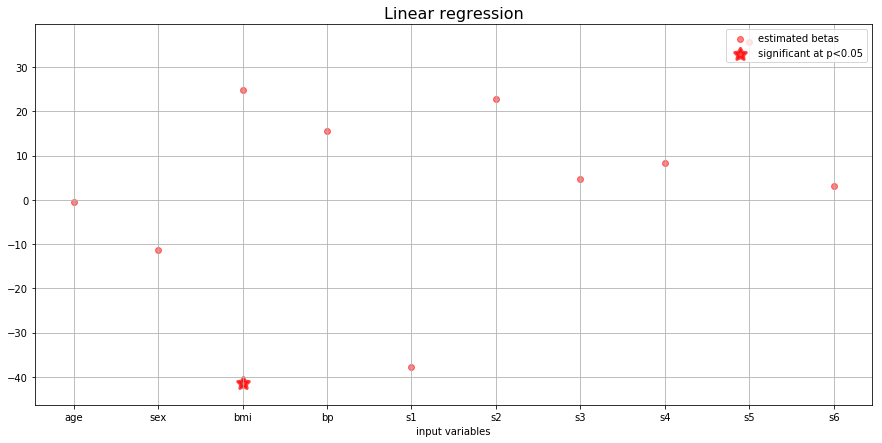

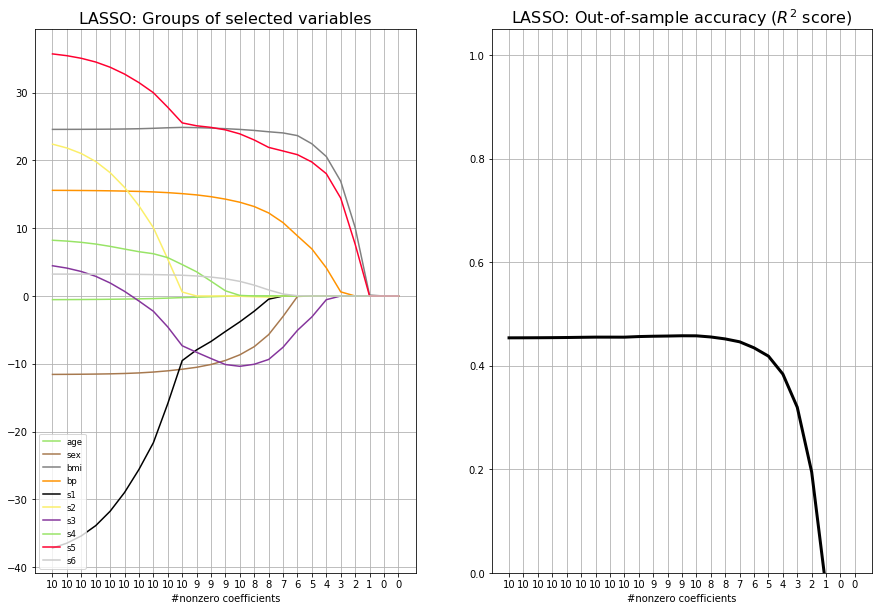

In [228]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-2, 2, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names)

### inference: only var 3 significant, prediction: this one is selected too but as predictive as var 9 and similar to 4 and 7 -> S5 is as predictive as bmi but not significant, same goes for bp and s3

In [34]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.100
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           4.72e-07
Time:                        15:20:58   Log-Likelihood:                -2873.9
No. Observations:                 442   AIC:                             5768.
Df Residuals:                     432   BIC:                             5809.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.4762      8.560     -0.056      0.9

# Prostata dataset

Prostate Cancer Data
Description
These data come from a study that examined the correlation between the level of prostate specific antigen and a number of clinical measures in men who were about to receive a radical prostatectomy. It is data frame with 97 rows and 9 columns.

Usage
data(Prostate)
Format
The data frame has the following components:

lcavol
log(cancer volume)
lweight
log(prostate weight)
age
age
lbph
log(benign prostatic hyperplasia amount)
svi
seminal vesicle invasion
lcp
log(capsular penetration)
gleason
Gleason score
pgg45
percentage Gleason scores 4 or 5
lpsa
log(prostate specific antigen)
Source
Stamey, T.A., Kabalin, J.N., McNeal, J.E., Johnstone, I.M., Freiha, F., Redwine, E.A. and Yang, N. (1989)
Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate: II. radical prostatectomy treated patients, Journal of Urology 141(5), 1076–1083.

Lasso paths from Hastie et al. 2001

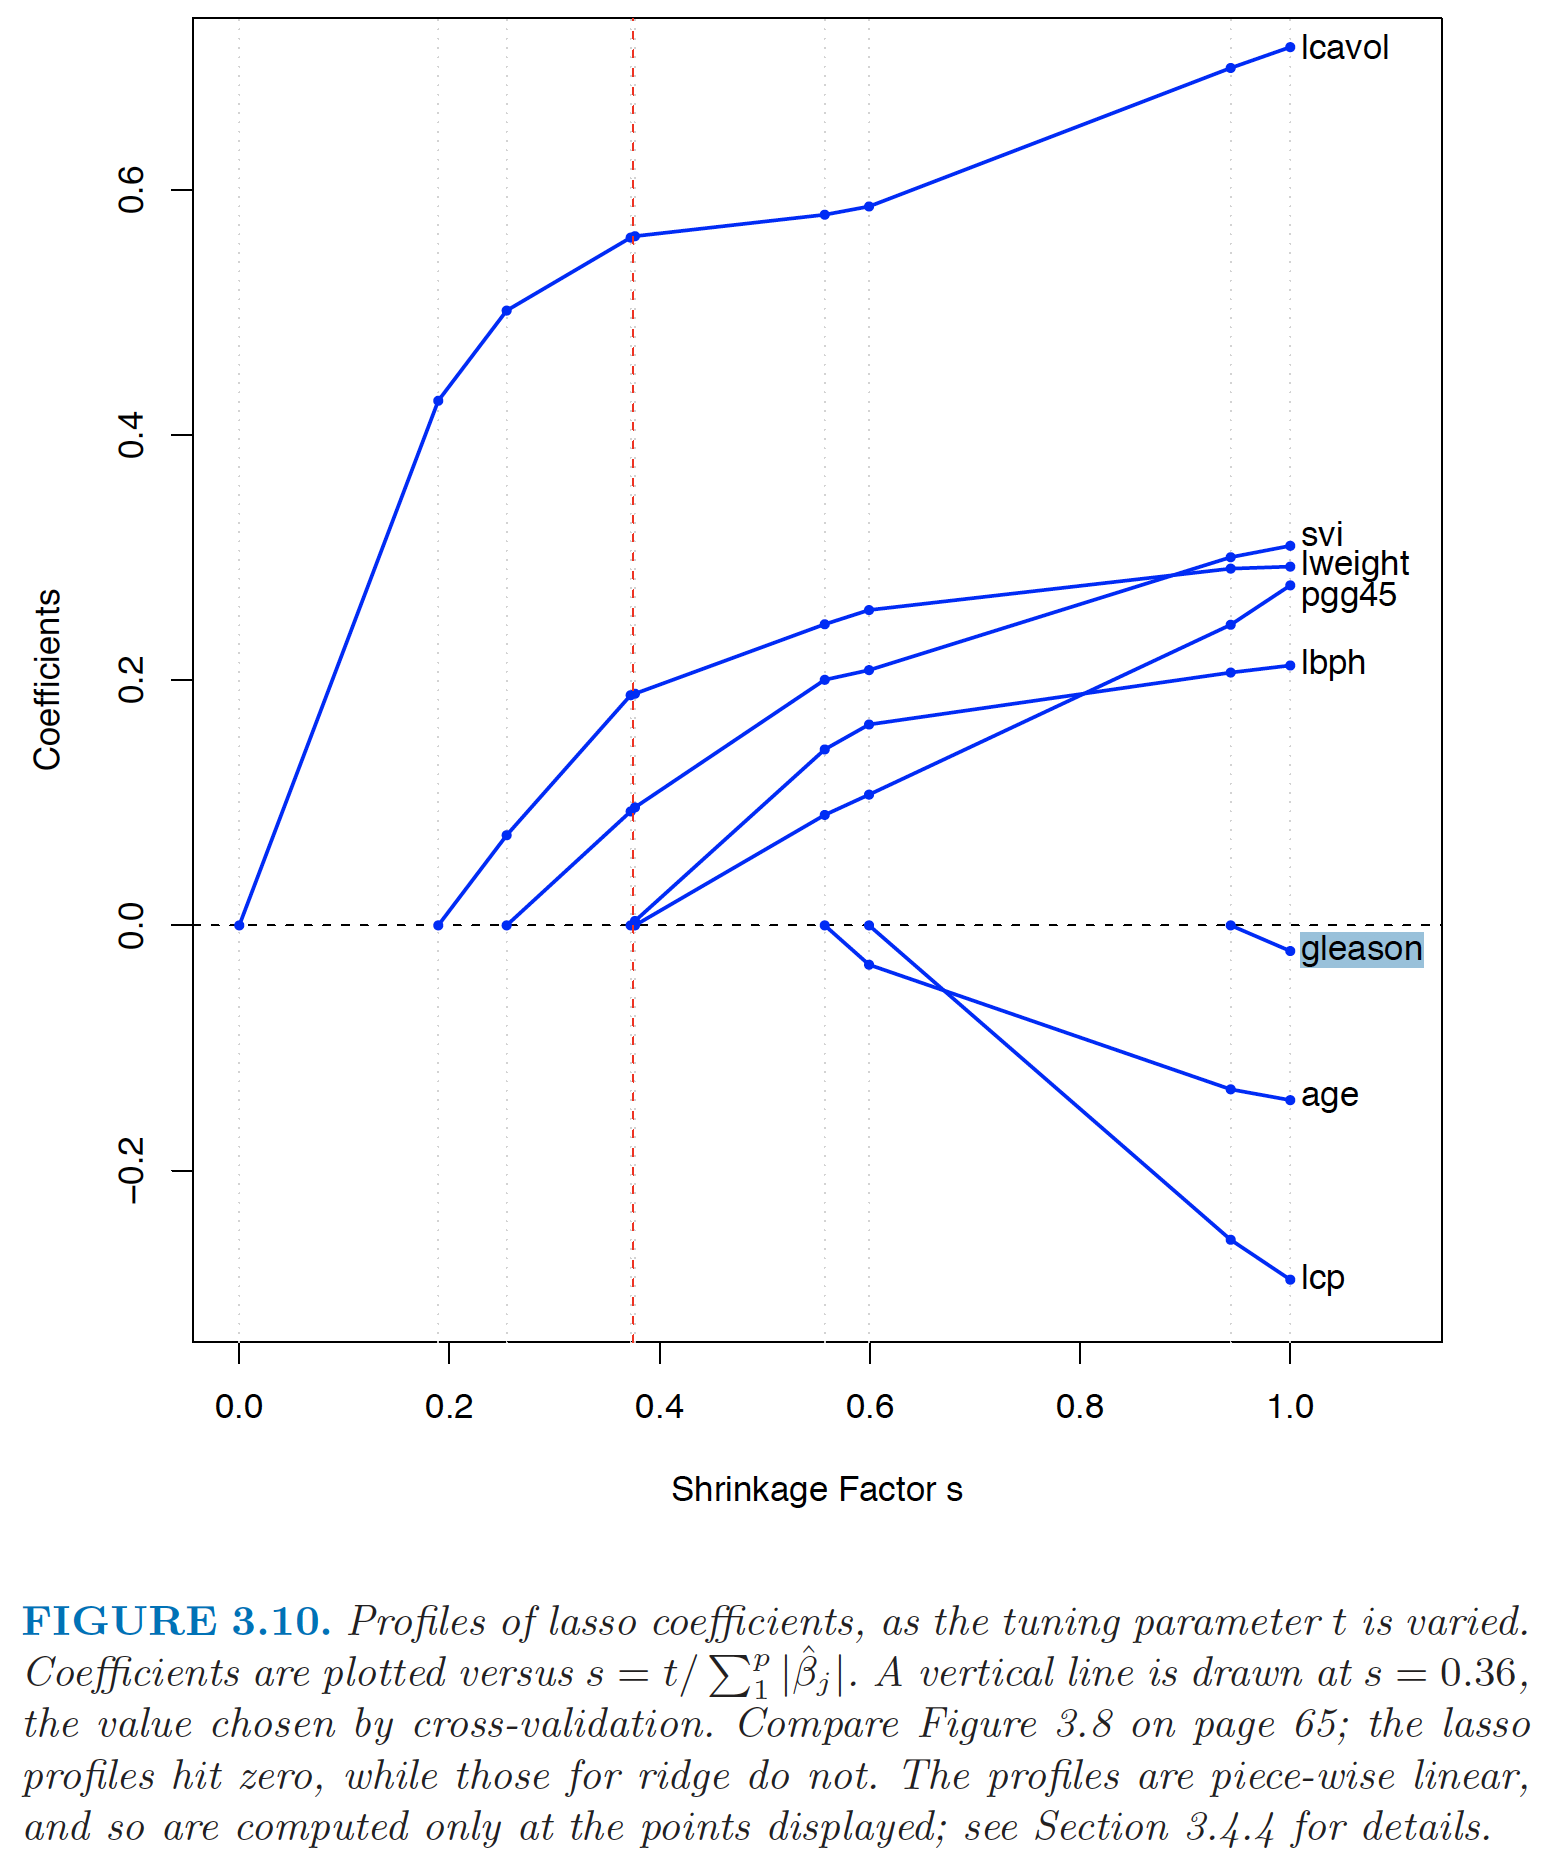

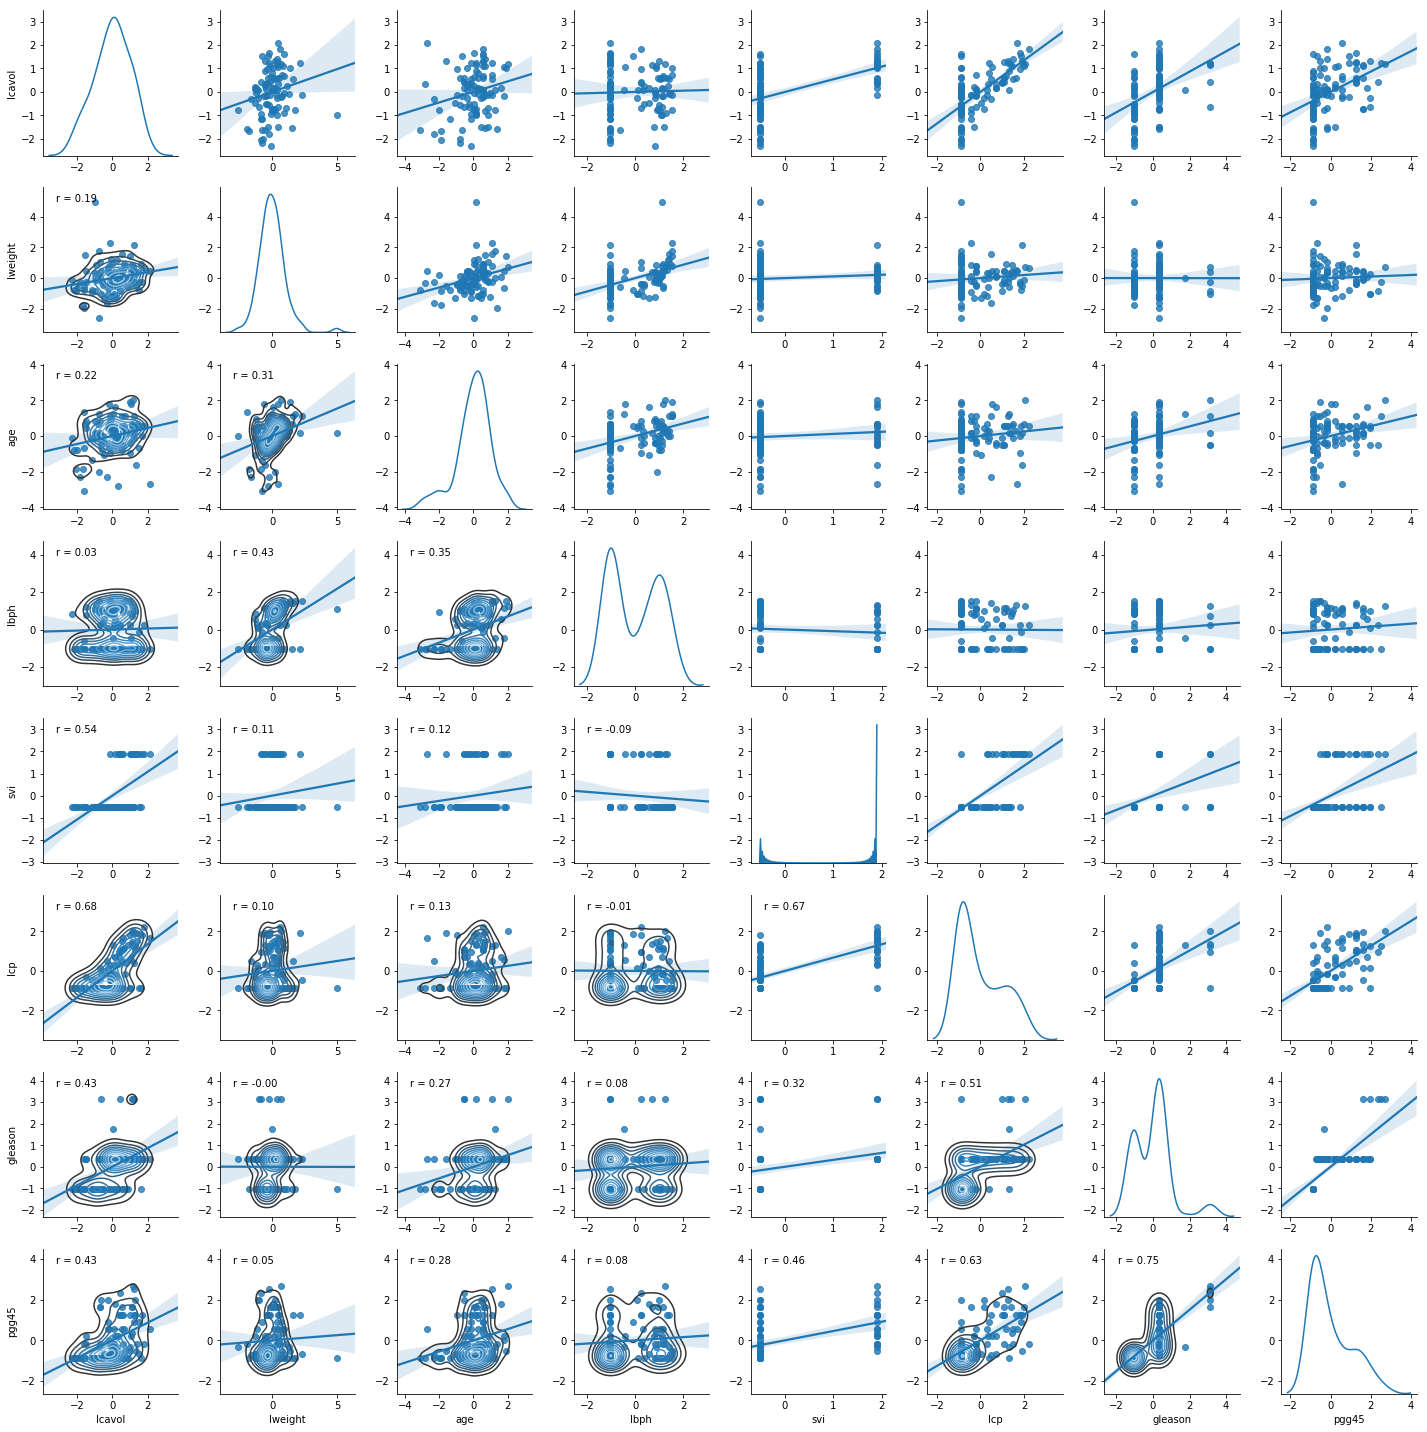

In [30]:
import pandas as pd
df_prostate = pd.read_csv('dataset_prostate.csv')
y = df_prostate['lpsa']
feat_names = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
X = StandardScaler().fit_transform(df_prostate[feat_names])

g = sns.pairplot(pd.DataFrame(X, columns=feat_names), kind="reg", diag_kind="kde")
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
#sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
#             kind="reg", diag_kind="kde", hue='out')

alpha: 0.0001 acc: -0.69 active_coefs: 8
alpha: 0.0002 acc: -0.69 active_coefs: 8
alpha: 0.0002 acc: -0.69 active_coefs: 8
alpha: 0.0003 acc: -0.69 active_coefs: 8
alpha: 0.0005 acc: -0.69 active_coefs: 8
alpha: 0.0008 acc: -0.68 active_coefs: 8
alpha: 0.0012 acc: -0.68 active_coefs: 8
alpha: 0.0017 acc: -0.68 active_coefs: 8
alpha: 0.0026 acc: -0.67 active_coefs: 8
alpha: 0.0039 acc: -0.66 active_coefs: 8
alpha: 0.0059 acc: -0.65 active_coefs: 8
alpha: 0.0089 acc: -0.63 active_coefs: 8
alpha: 0.0133 acc: -0.60 active_coefs: 8
alpha: 0.0200 acc: -0.56 active_coefs: 8
alpha: 0.0301 acc: -0.49 active_coefs: 8
alpha: 0.0453 acc: -0.40 active_coefs: 7
alpha: 0.0681 acc: -0.28 active_coefs: 8
alpha: 0.1024 acc: -0.13 active_coefs: 7
alpha: 0.1540 acc: 0.02 active_coefs: 5
alpha: 0.2315 acc: 0.13 active_coefs: 5
alpha: 0.3481 acc: 0.14 active_coefs: 3
alpha: 0.5233 acc: 0.03 active_coefs: 2
alpha: 0.7867 acc: -0.41 active_coefs: 1
alpha: 1.1828 acc: -0.64 active_coefs: 0
alpha: 1.7783 acc: -

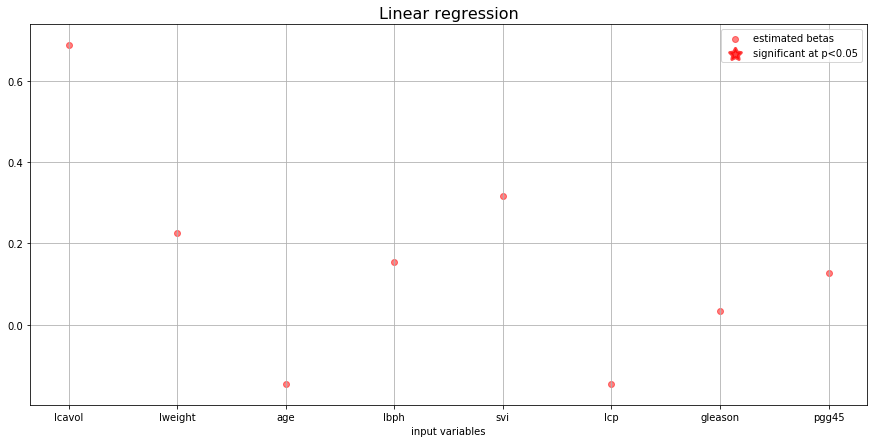

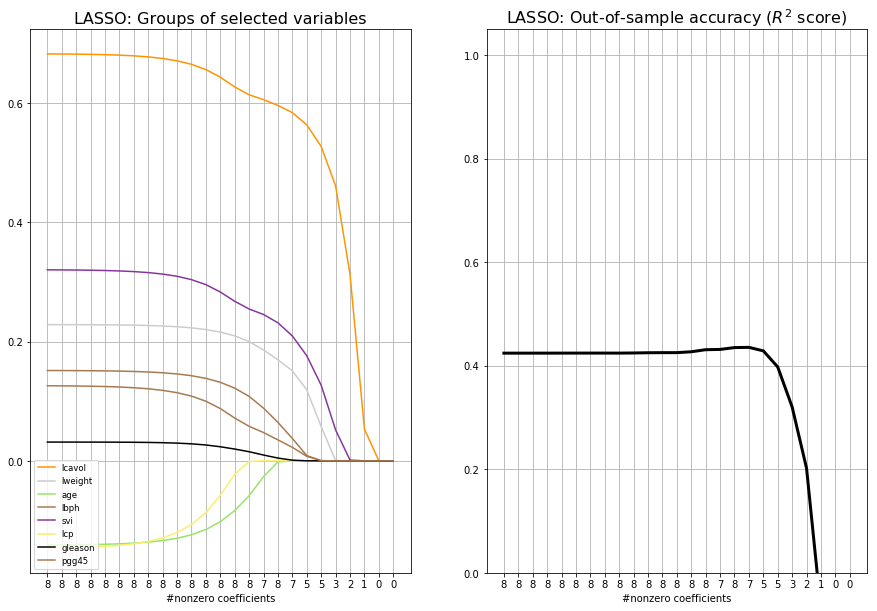

In [71]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names)

### no significants (trending significant at 0.08 is also single most predictive variable); 7 items not full set of 9 variables were most predictive -> the widely practiced Gleason score (?) comes up as distrubing prediction

In [69]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.456
Date:                Thu, 08 Mar 2018   Prob (F-statistic):              0.185
Time:                        18:25:46   Log-Likelihood:                -229.14
No. Observations:                  97   AIC:                             474.3
Df Residuals:                      89   BIC:                             494.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lcavol         0.6883      0.390      1.764      0.0

# Heart dataset (ISL)

In [35]:
These data contain a binary outcome HD for 303 patients who presented with chest pain (binary outcome). 

SyntaxError: invalid syntax (<ipython-input-35-4abbd2cfe546>, line 1)

In [39]:
import pandas as pd
df_heart = pd.read_csv('dataset_heart_ISL.csv').fillna(value=0)
feat_names = ['Age', u'Sex', u'RestBP', u'Chol', u'Fbs',
       u'RestECG', u'MaxHR', u'ExAng', u'Oldpeak', u'Slope', u'Ca', u'Thal', u'ChestPain']
y = np.asarray(df_heart['AHD'] == 'Yes', dtype=np.float)

df_part1 = pd.DataFrame(StandardScaler().fit_transform(df_heart[feat_names[:-2]].values), columns=feat_names[:-2])
df_part2 = pd.get_dummies(df_heart[feat_names[-2:]])
#pd.concat([df_part1.reset_index() + df_part2.reset_index()], axis=1)
X = np.hstack((df_part1.values, df_part2.values))
feat_names = list(df_part1.columns) + list(df_part2.columns)

g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
             kind="reg", diag_kind="kde", hue='out')
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

/Users/admin/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


alpha: 0.0001 acc: 0.36 active_coefs: 19
alpha: 0.0002 acc: 0.36 active_coefs: 19
alpha: 0.0002 acc: 0.36 active_coefs: 19
alpha: 0.0003 acc: 0.36 active_coefs: 19
alpha: 0.0005 acc: 0.36 active_coefs: 19
alpha: 0.0008 acc: 0.36 active_coefs: 19
alpha: 0.0012 acc: 0.36 active_coefs: 19
alpha: 0.0017 acc: 0.36 active_coefs: 18
alpha: 0.0026 acc: 0.36 active_coefs: 17
alpha: 0.0039 acc: 0.36 active_coefs: 17
alpha: 0.0059 acc: 0.37 active_coefs: 17
alpha: 0.0089 acc: 0.37 active_coefs: 16
alpha: 0.0133 acc: 0.37 active_coefs: 14
alpha: 0.0200 acc: 0.37 active_coefs: 14
alpha: 0.0301 acc: 0.37 active_coefs: 12
alpha: 0.0453 acc: 0.36 active_coefs: 11
alpha: 0.0681 acc: 0.33 active_coefs: 9
alpha: 0.1024 acc: 0.27 active_coefs: 6
alpha: 0.1540 acc: 0.19 active_coefs: 4
alpha: 0.2315 acc: -0.00 active_coefs: 3
alpha: 0.3481 acc: -0.00 active_coefs: 0
alpha: 0.5233 acc: -0.00 active_coefs: 0
alpha: 0.7867 acc: -0.00 active_coefs: 0
alpha: 1.1828 acc: -0.00 active_coefs: 0
alpha: 1.7783 acc: 

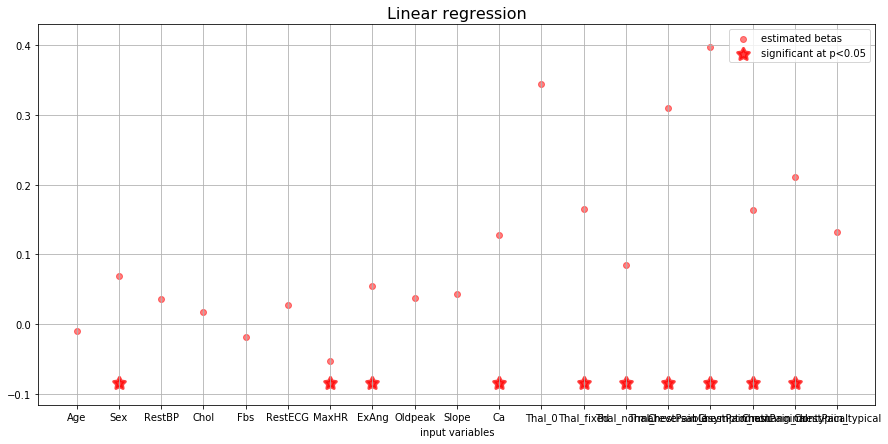

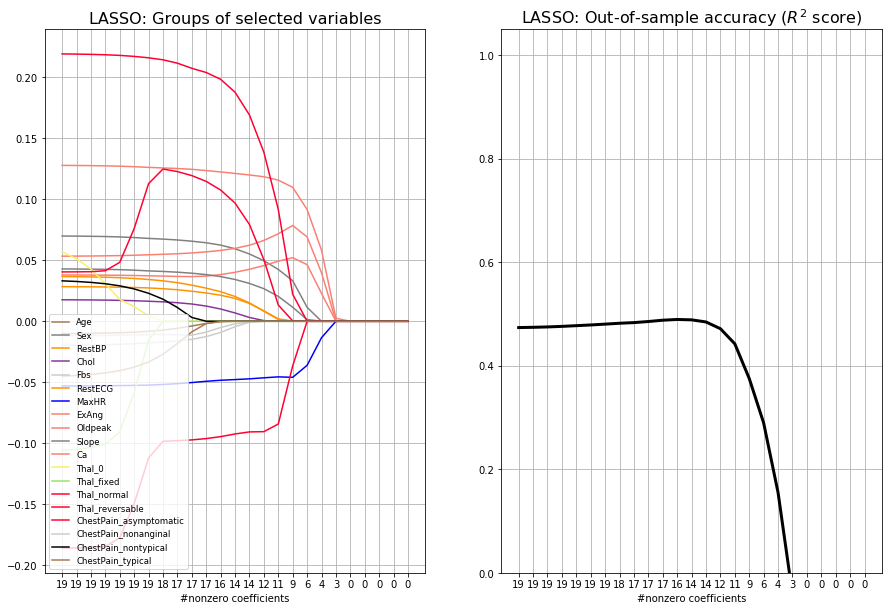

In [37]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names)

In [38]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     20.58
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           4.04e-40
Time:                        17:39:17   Log-Likelihood:                -97.524
No. Observations:                 303   AIC:                             231.0
Df Residuals:                     285   BIC:                             297.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Age                       -0

# South African Heart dataset (ESL)

A retrospective sample of males in a heart-disease high-risk region of the Western Cape, South Africa.
There are roughly two controls per case of coronary heart disease. Many of the coronary heart disease
positive men have undergone blood pressure reduction treatment and other programs to reduce their risk
factors after their coronary heart disease event. In some cases the measurements were made after these
treatments. These data are taken from a larger dataset, described in Rousseauw et al, 1983, South African
Medical Journal.

Based on this data, does having a family history of coronary heart disease affect a patients chance of
having coronary heart disease? Does this result change for patients younger than 40 years old? What
about for patients aged 40 years or older?

sbp		systolic blood pressure
tobacco		cumulative tobacco (kg)
ldl		low densiity lipoprotein cholesterol
adiposity
famhist		family history of heart disease (Present, Absent)
typea		type-A behavior
obesity
alcohol		current alcohol consumption
age		age at onset
chd		response, coronary heart disease

In [41]:
import pandas as pd
df_africa = pd.read_excel('dataset_south_african_heart_disease.xls')

df_africa

row  sbp  tobacco    ldl  adiposity  famhist  typea  obesity  alcohol  \
0      1  160    12.00   5.73      23.11  Present     49    25.30    97.20   
1      2  144     0.01   4.41      28.61   Absent     55    28.87     2.06   
2      3  118     0.08   3.48      32.28  Present     52    29.14     3.81   
3      4  170     7.50   6.41      38.03  Present     51    31.99    24.26   
4      5  134    13.60   3.50      27.78  Present     60    25.99    57.34   
5      6  132     6.20   6.47      36.21  Present     62    30.77    14.14   
6      7  142     4.05   3.38      16.20   Absent     59    20.81     2.62   
7      8  114     4.08   4.59      14.60  Present     62    23.11     6.72   
8      9  114     0.00   3.83      19.40  Present     49    24.86     2.49   
9     10  132     0.00   5.80      30.96  Present     69    30.11     0.00   
10    11  206     6.00   2.95      32.27   Absent     72    26.81    56.06   
11    12  134    14.10   4.44      22.39  Present     65    23.09     0.00   
12    13  118     0.00   1.88      10.05   Absent     59    21.57     0.00   
13    14  132     0.00   1.87      17.21   Absent     49    23.63     0.97   
14    15  112     9.65   2.29      17.20  Present     54    23.53     0.68   
15    16  117     1.53   2.44      28.95  Present     35    25.89    30.03   
16    17  120     7.50  15.33      22.00   Absent     60    25.31    34.49   
17    18  146    10.50   8.29      35.36  Present     78    32.73    13.89   
18    19  158     2.60   7.46      34.07  Present     61    29.30    53.28   
19    20  124    14.00   6.23      35.96  Present     45    30.09     0.00   
20    21  106     1.61   1.74      12.32   Absent     74    20.92    13.37   
21    22  132     7.90   2.85      26.50  Present     51    26.16    25.71   
22    23  150     0.30   6.38      33.99  Present     62    24.64     0.00   
23    24  138     0.60   3.81      28.66   Absent     54    28.70     1.46   
24    25  142    18.20   4.34      24.38   Absent     61    26.19     0.00   
25    26  124     4.00  12.42      31.29  Present     54    23.23     2.06   
26    27  118     6.00   9.65      33.91   Absent     60    38.80     0.00   
27    28  145     9.10   5.24      27.55   Absent     59    20.96    21.60   
28    29  144     4.09   5.55      31.40  Present     60    29.43     5.55   
29    30  146     0.00   6.62      25.69   Absent     60    28.07     8.23   
..   ...  ...      ...    ...        ...      ...    ...      ...      ...   
432  434  136     0.00   4.00      19.06   Absent     40    21.94     2.06   
433  435  120     0.00   2.46      13.39   Absent     47    22.01     0.51   
434  436  132     0.00   3.55       8.66  Present     61    18.50     3.87   
435  437  136     0.00   1.77      20.37   Absent     45    21.51     2.06   
436  438  138     0.00   1.86      18.35  Present     59    25.38     6.51   
437  439  138     0.06   4.15      20.66   Absent     49    22.59     2.49   
438  440  130     1.22   3.30      13.65   Absent     50    21.40     3.81   
439  441  130     4.00   2.40      17.42   Absent     60    22.05     0.00   
440  442  110     0.00   7.14      28.28   Absent     57    29.00     0.00   
441  443  120     0.00   3.98      13.19  Present     47    21.89     0.00   
442  444  166     6.00   8.80      37.89   Absent     39    28.70    43.20   
443  445  134     0.57   4.75      23.07   Absent     67    26.33     0.00   
444  446  142     3.00   3.69      25.10   Absent     60    30.08    38.88   
445  447  136     2.80   2.53       9.28  Present     61    20.70     4.55   
446  448  142     0.00   4.32      25.22   Absent     47    28.92     6.53   
447  449  130     0.00   1.88      12.51  Present     52    20.28     0.00   
448  450  124     1.80   3.74      16.64  Present     42    22.26    10.49   
449  451  144     4.00   5.03      25.78  Present     57    27.55    90.00   
450  452  136     1.81   3.31       6.74   Absent     63    19.57    24.94   
451  453  120     0.00   2.

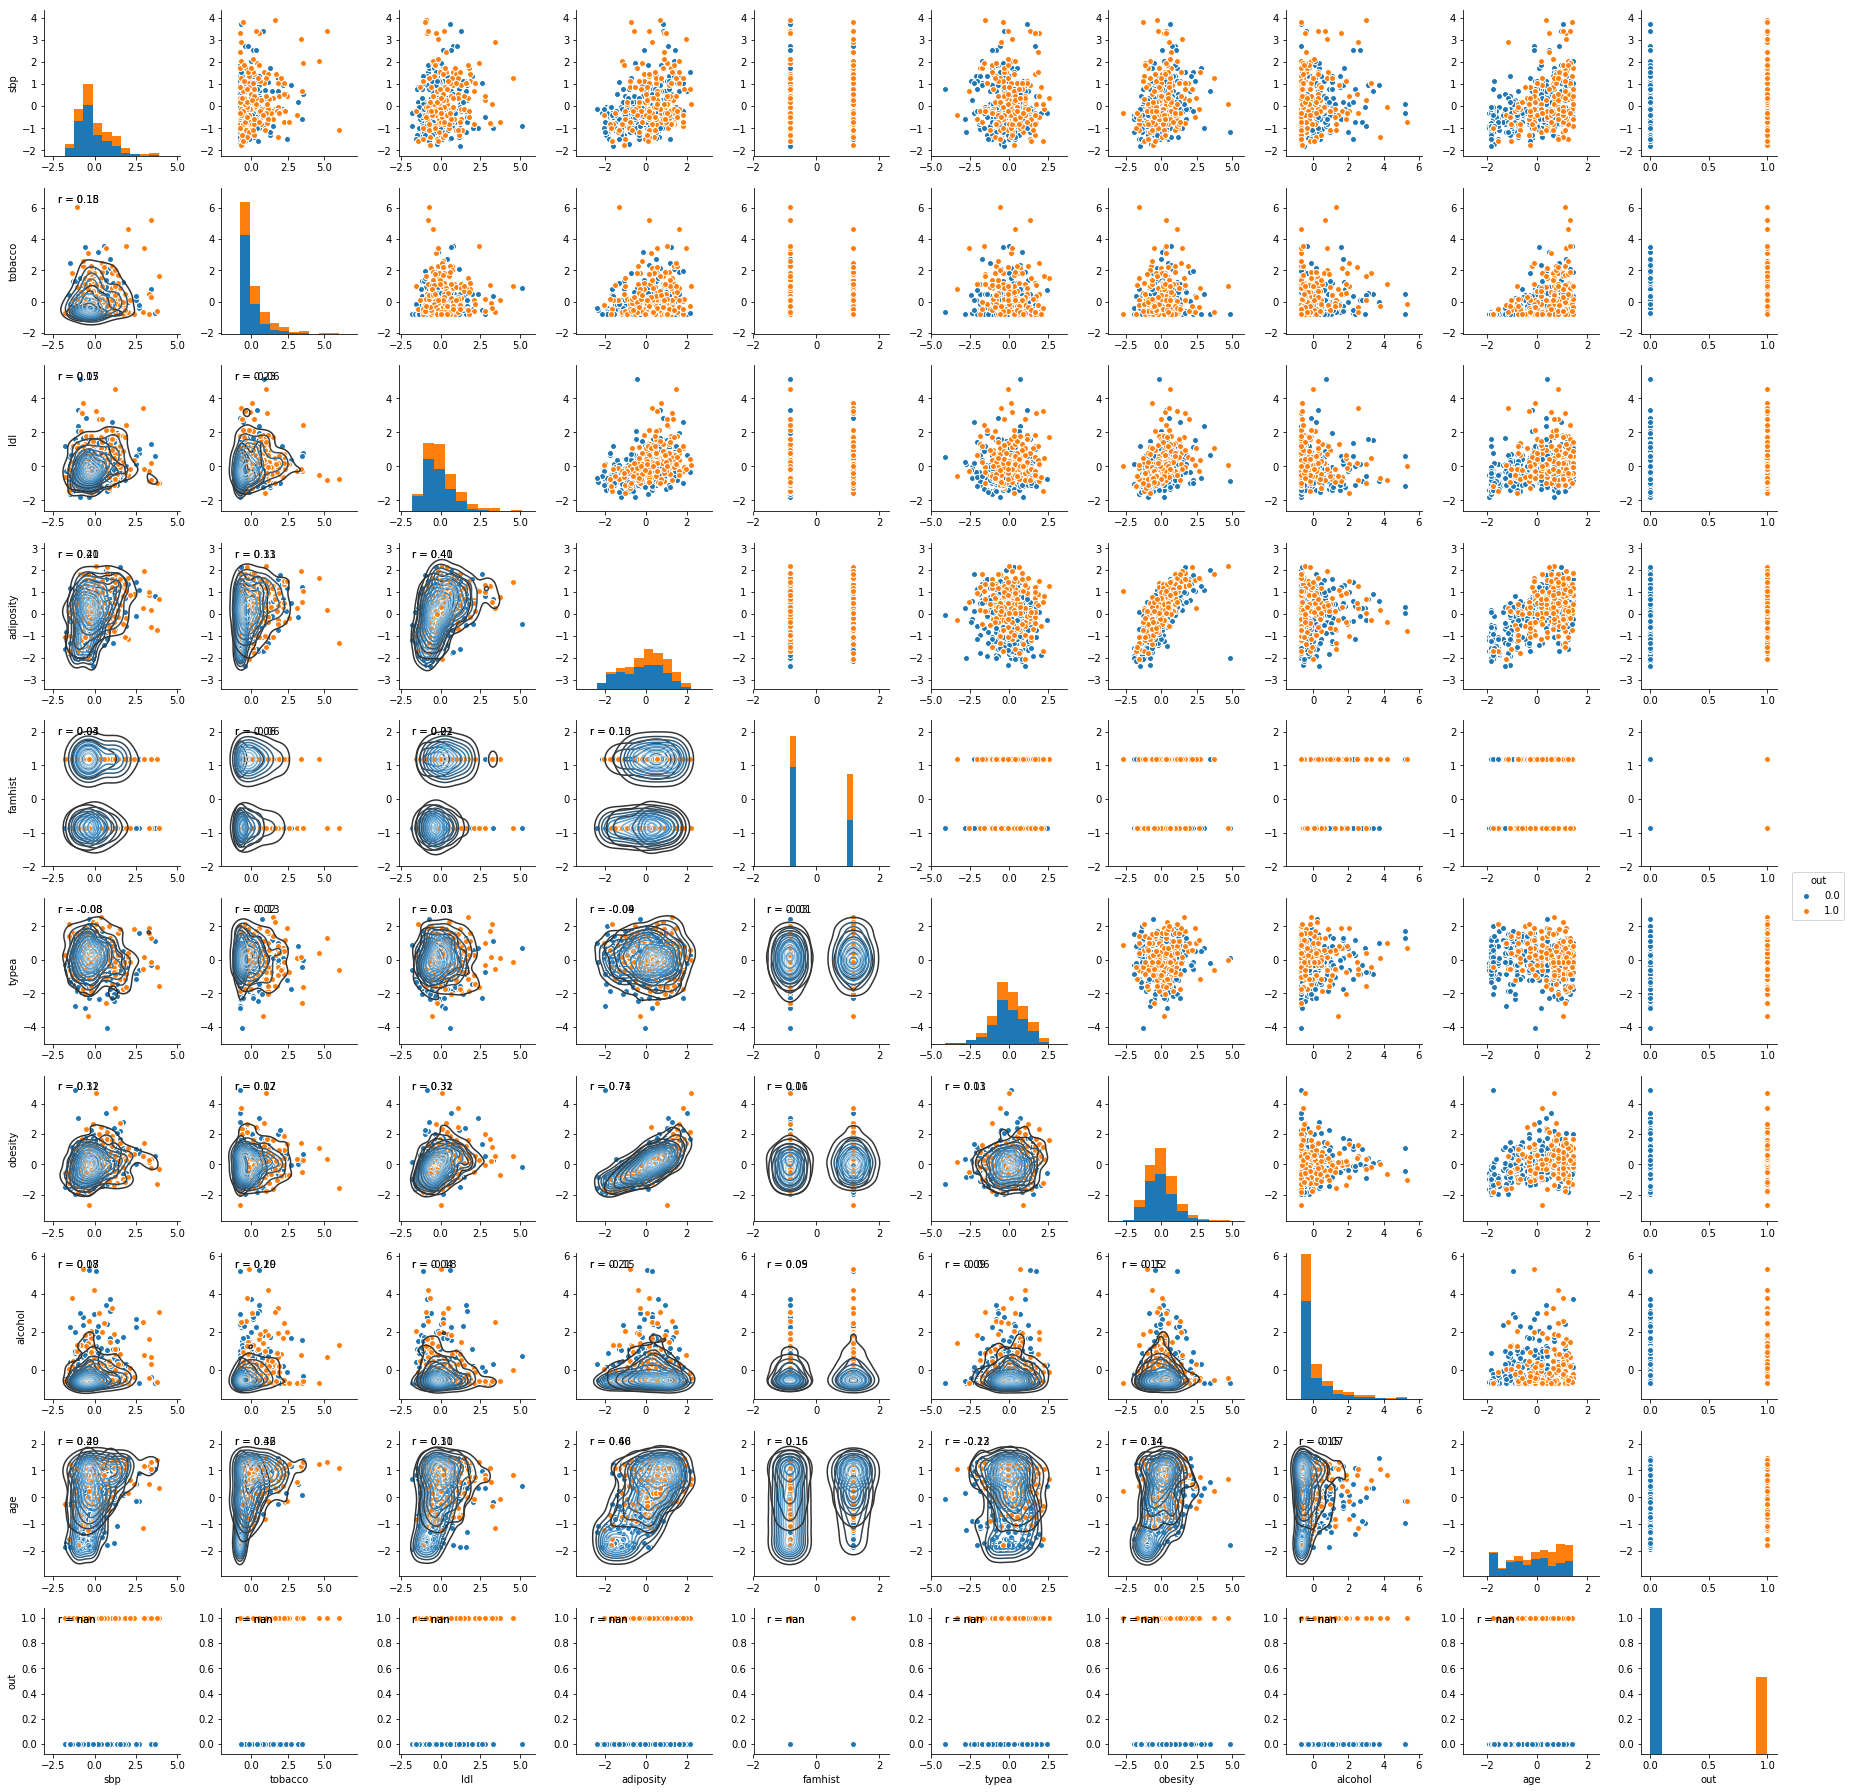

In [42]:
feat_names = ['sbp', u'tobacco', u'ldl', u'adiposity', u'famhist', u'typea',
       u'obesity', u'alcohol', u'age']
df_africa['famhist'] = df_africa['famhist'] == 'Present'
X = StandardScaler().fit_transform(df_africa[feat_names].values)
y = df_africa['chd'].values

g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
              hue='out')
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

alpha: 0.0001 acc: 0.34 active_coefs: 9
alpha: 0.0002 acc: 0.34 active_coefs: 9
alpha: 0.0002 acc: 0.34 active_coefs: 9
alpha: 0.0003 acc: 0.34 active_coefs: 9
alpha: 0.0005 acc: 0.34 active_coefs: 9
alpha: 0.0008 acc: 0.34 active_coefs: 9
alpha: 0.0012 acc: 0.35 active_coefs: 9
alpha: 0.0017 acc: 0.35 active_coefs: 9
alpha: 0.0026 acc: 0.35 active_coefs: 9
alpha: 0.0039 acc: 0.35 active_coefs: 9
alpha: 0.0059 acc: 0.36 active_coefs: 9
alpha: 0.0089 acc: 0.36 active_coefs: 9
alpha: 0.0133 acc: 0.36 active_coefs: 8
alpha: 0.0200 acc: 0.35 active_coefs: 8
alpha: 0.0301 acc: 0.33 active_coefs: 7
alpha: 0.0453 acc: 0.30 active_coefs: 6
alpha: 0.0681 acc: 0.24 active_coefs: 5
alpha: 0.1024 acc: 0.12 active_coefs: 4
alpha: 0.1540 acc: 0.01 active_coefs: 1
alpha: 0.2315 acc: -0.02 active_coefs: 0
alpha: 0.3481 acc: -0.02 active_coefs: 0
alpha: 0.5233 acc: -0.02 active_coefs: 0
alpha: 0.7867 acc: -0.02 active_coefs: 0
alpha: 1.1828 acc: -0.02 active_coefs: 0
alpha: 1.7783 acc: -0.02 active_coe

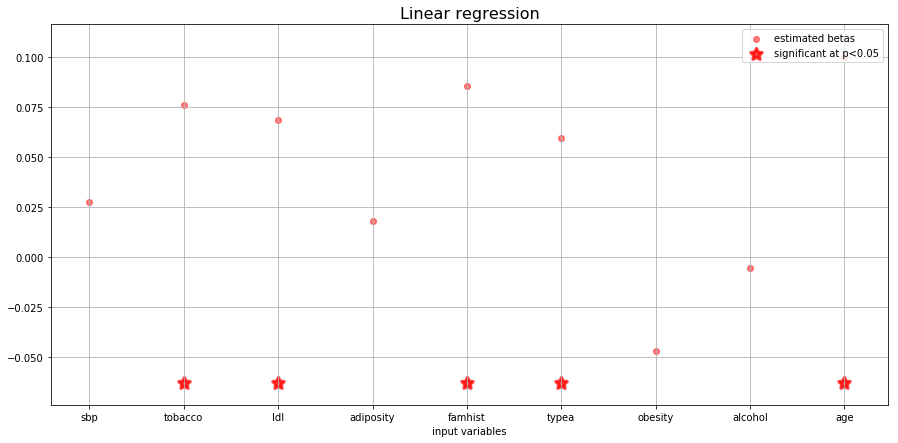

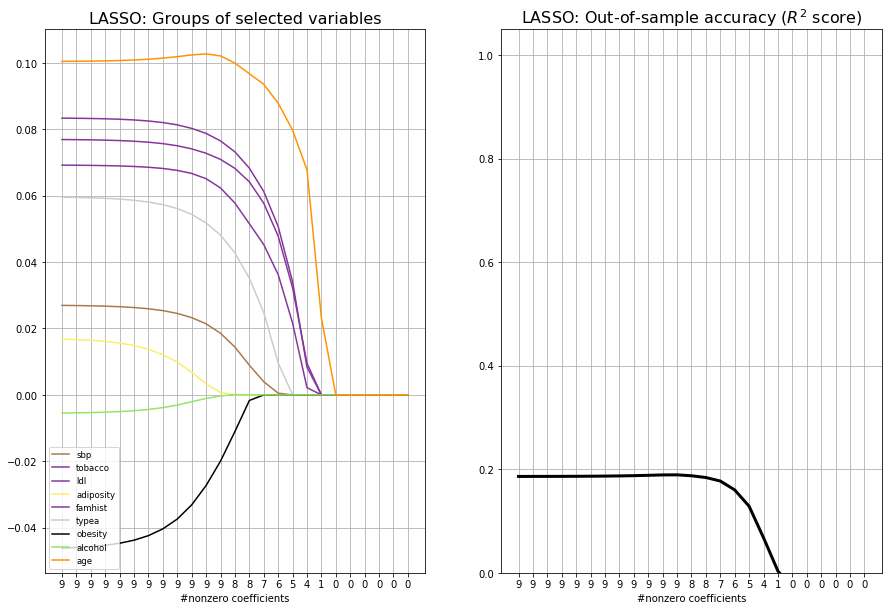

In [26]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names)


### conclusion: largely in agreement; the 5 significant variables are also the 5 most predictive variables -> sbp and obesity are 6. and 7. most predictive variables but they are not among the significant ones (p > 0.2 and p > 0.3)

In [28]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     9.182
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           8.04e-13
Time:                        15:54:49   Log-Likelihood:                -371.89
No. Observations:                 462   AIC:                             761.8
Df Residuals:                     453   BIC:                             799.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sbp            0.0274      0.028      0.973      0.3